# Задача 5. Обучение без учителя

* **Дедлайн**: 14.04.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

# Датасет
В качестве датасета будем использовать https://www.kaggle.com/datasets/oddrationale/mnist-in-csv. Он состоит из 60000 черно-белых изображений 28x28 пикселей, содержащий цифры от 0 до 9. Отсюда очевидно, что датасет содержит 10 разных классов.

Будем решать на этом датасете задачу кластеризации

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('mnist_train.csv')

In [3]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
labels = df["label"]
labels.value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

Уберем лейблы из датасета.

In [5]:
df.drop(columns=['label'], inplace=True)

# EDA

Попробуем изобразить данные посредством понижения размерности. Затем выясним, насколько сильно можем понизить размерность без больших потерь информации.

## Визуализация с помощью PCA и t-SNE
Визуализируем данные при помощи понижения размерности до двух

In [6]:
from sklearn.decomposition import PCA

In [7]:
%%time
pca = PCA()
pca_res = pca.fit_transform(df)

CPU times: total: 47.3 s
Wall time: 11.7 s


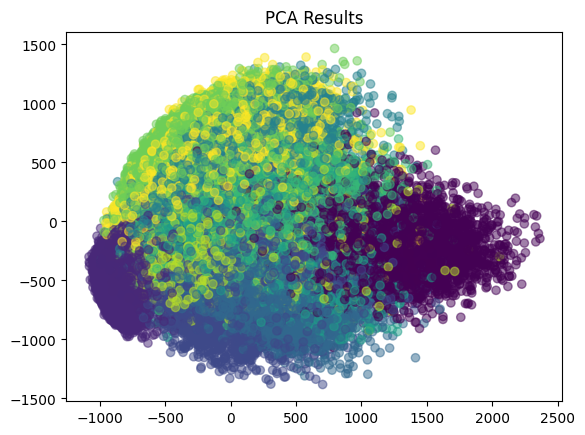

In [8]:
plt.scatter(pca_res[:,0], pca_res[:,1], c=labels, alpha=0.5)
plt.title('PCA Results');

В верхней, нижней, левой и правой части области видно довольно четкое резделеные на кластеры, однако по середине цвета смешиваются, что не позволяет зрительно разделить области.

Ввиду этого попробуем алгоритм t-SNE, который, вероятно, позволит визиуализировать данные с более четким разделением на кластера:

In [9]:
from sklearn.manifold import TSNE

In [10]:
%%time
tsne_res = TSNE().fit_transform(df)

CPU times: total: 58min 32s
Wall time: 9min 18s


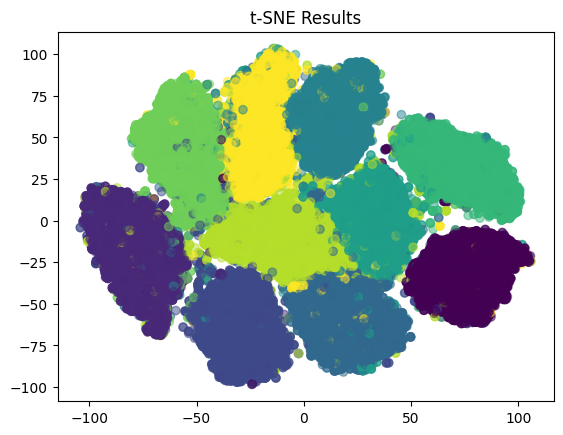

In [11]:
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=labels, alpha=0.5)
plt.title('t-SNE Results');

Теперь гораздо лучше. Можно легко зрительно выделить 10 кластеров. Однако все равно существует область, где точки разных цветов накладываются друг на друга

## Понижение размерности

Теперь проверим, все ли пиксели используются. Если нет, то попробуем снизить размерность

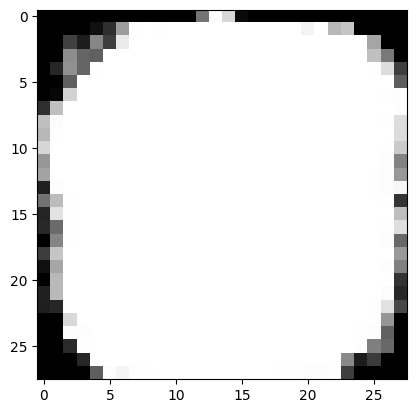

In [12]:
used = df.max().values
plt.imshow(used.reshape((28, 28)), cmap='gray');

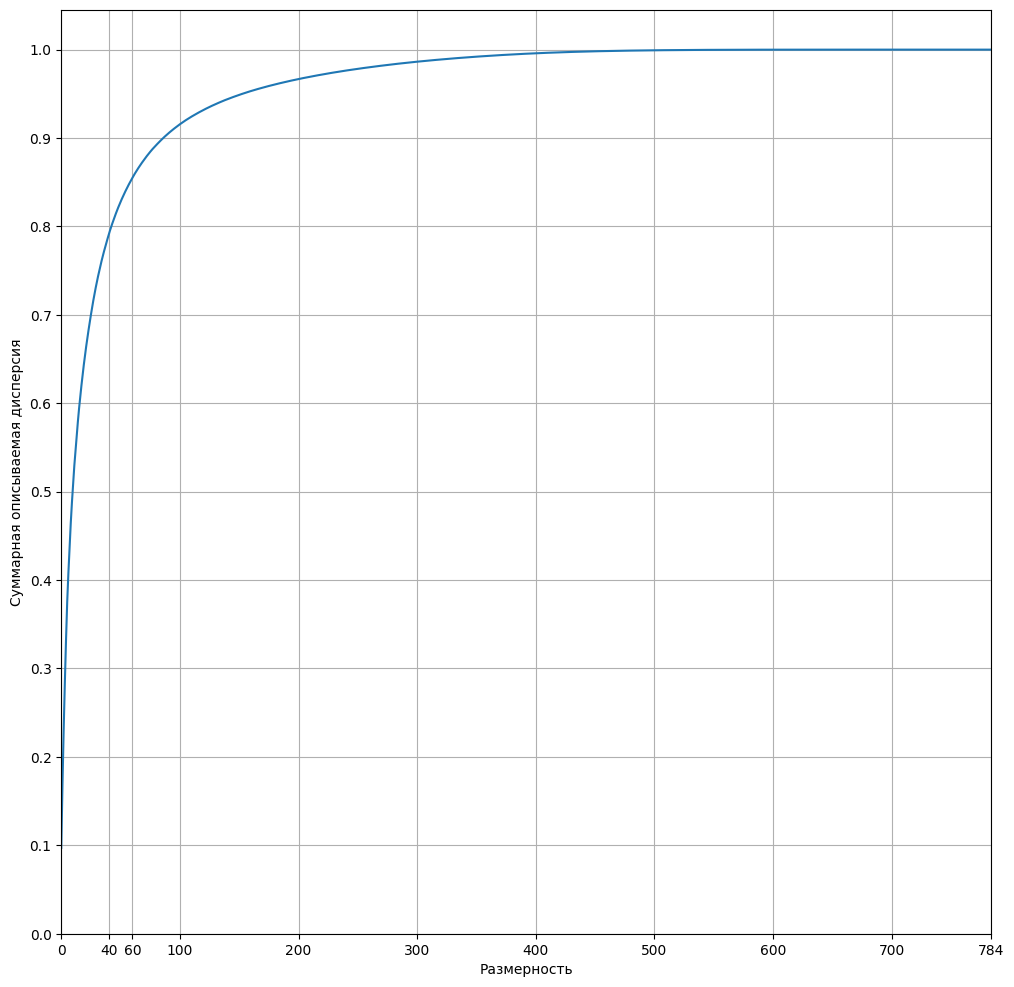

In [13]:
plt.figure(figsize=(12, 12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Суммарная описываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks([*plt.xticks()[0], 40, 60, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

Можно заметить, что размерность 40 позволяет описать практически 80% дисперсии, 60 - более 85%, 100 - более 90%. Начиная с размерности 400 добавление новых измерений практически не привносит новой информации.

# Обучение

Начнем с собственной простой реализации KMeans

In [14]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator


class SimpleKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)

        self.n_features_in_ = X.shape[1]

        self.cluster_centers_ = X[
            self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :
        ]

        max_center_shift = np.inf
        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(X)

            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))

            self.cluster_centers_ = new_centers

        return self

    def predict(self, X):
        check_is_fitted(self)
        return self._get_labels(check_array(X))
    
    def _get_labels(self, X):
        return np.argmin(
            np.linalg.norm(X[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )


check_estimator(SimpleKMeans())

## Выбор метрик

В рамках этой задачи будем пользоваться 
* Adjusted Rand Index (ARI)
* Adjusted Mutual Information (AMI)
* Fowlkes-Mallows Index (FMI)

In [15]:
%%time
Xs = [df, *(PCA(n_components=d).fit_transform(df) for d in [40, 60, 100, 400])]

CPU times: total: 3min
Wall time: 31.7 s


In [16]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

RESULTS_PATH = pathlib.Path("learning_results.csv")

def combs(grid):
    return [
        dict(params) 
        for params in
        itertools.product(
            *(
                [(name, v) for v in vs]
                for (name, vs)
                in grid.items()
            )
        )
    ]

def train_and_save(estimator, param_grid):
    param_combs = combs(param_grid)

    results = []
    for X in Xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for params in param_combs:
            e = clone(estimator).set_params(**params)
            start_t = time.perf_counter()
            pred = e.fit_predict(X)
            fit_predict_time_s = (time.perf_counter() - start_t)
            ari = adjusted_rand_score(labels, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time_s, params
            ami = adjusted_mutual_info_score(labels, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time_s, params
            fmi = fowlkes_mallows_score(labels, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time_s, params

        res_dict = {
                "Clusterer": estimator.__class__.__name__,
                "Dimension": X.shape[1],
                "Mean F/P time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
                "ARI": best_ari[0],
                "AMI": best_ami[0],
                "FMI": best_fmi[0],
            }        
        print(res_dict)
        results.append(res_dict)
        
    pd.DataFrame(results).to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

In [17]:
N_CLUSTERS=10

In [18]:
%%time

train_and_save(SimpleKMeans(n_clusters=N_CLUSTERS, random_state=0),
              param_grid={})

{'Clusterer': 'SimpleKMeans', 'Dimension': 784, 'Mean F/P time, s': 339.7166034999973, 'ARI': 0.3925056400687111, 'AMI': 0.50399751344985, 'FMI': 0.4555969422809995}
{'Clusterer': 'SimpleKMeans', 'Dimension': 40, 'Mean F/P time, s': 9.73280689999956, 'ARI': 0.4041636681484236, 'AMI': 0.5173685450431033, 'FMI': 0.4647959242228357}
{'Clusterer': 'SimpleKMeans', 'Dimension': 60, 'Mean F/P time, s': 19.644559799999115, 'ARI': 0.40566806223892626, 'AMI': 0.5188389315874318, 'FMI': 0.46613652423935803}
{'Clusterer': 'SimpleKMeans', 'Dimension': 100, 'Mean F/P time, s': 27.87445509999816, 'ARI': 0.4048091201418969, 'AMI': 0.5185388518327451, 'FMI': 0.46538506165771254}
{'Clusterer': 'SimpleKMeans', 'Dimension': 400, 'Mean F/P time, s': 140.7253062000018, 'ARI': 0.3924804162575355, 'AMI': 0.5039261862733502, 'FMI': 0.45557425067480256}
CPU times: total: 8min 47s
Wall time: 8min 58s


In [19]:
%%time
from sklearn.cluster import KMeans

train_and_save(KMeans(n_clusters=N_CLUSTERS, n_init='auto', random_state=0),
               param_grid={"algorithm": ["lloyd", "elkan"]})

{'Clusterer': 'KMeans', 'Dimension': 784, 'Mean F/P time, s': 6.9852261999985785, 'ARI': 0.3596611790613654, 'AMI': 0.48108679806592924, 'FMI': 0.4247580021179076}
{'Clusterer': 'KMeans', 'Dimension': 40, 'Mean F/P time, s': 0.2660572000022512, 'ARI': 0.3609662182401765, 'AMI': 0.4895673264215493, 'FMI': 0.4275645353174647}
{'Clusterer': 'KMeans', 'Dimension': 60, 'Mean F/P time, s': 0.23241050000069663, 'ARI': 0.3805725712841391, 'AMI': 0.4926093526996521, 'FMI': 0.446798400511427}
{'Clusterer': 'KMeans', 'Dimension': 100, 'Mean F/P time, s': 0.790554000006523, 'ARI': 0.3924890236136055, 'AMI': 0.5039508714802262, 'FMI': 0.45558221244161134}
{'Clusterer': 'KMeans', 'Dimension': 400, 'Mean F/P time, s': 1.5771921999985352, 'ARI': 0.3787671705583176, 'AMI': 0.49209077710308935, 'FMI': 0.4452630164889487}
CPU times: total: 1min 54s
Wall time: 18.2 s


In [20]:
%%time
from sklearn.cluster import DBSCAN

train_and_save(DBSCAN(n_jobs=-1), # use all processors 
               param_grid={"eps": [400, 800, 1200],
                            "min_samples": [20, 40, 80]})

{'Clusterer': 'DBSCAN', 'Dimension': 784, 'Mean F/P time, s': 216.64840280000013, 'ARI': 0.09826872875182638, 'AMI': 0.25745129964322616, 'FMI': 0.3451944910500865}
{'Clusterer': 'DBSCAN', 'Dimension': 40, 'Mean F/P time, s': 10.01069250000243, 'ARI': 0.09760396633630301, 'AMI': 0.2618236126756204, 'FMI': 0.33893313423097593}
{'Clusterer': 'DBSCAN', 'Dimension': 60, 'Mean F/P time, s': 13.473122466668428, 'ARI': 0.06940651513771628, 'AMI': 0.27081352462409375, 'FMI': 0.34456509537948793}
{'Clusterer': 'DBSCAN', 'Dimension': 100, 'Mean F/P time, s': 20.85674133333426, 'ARI': 0.10742966210054532, 'AMI': 0.2604244750889349, 'FMI': 0.34794486851186096}
{'Clusterer': 'DBSCAN', 'Dimension': 400, 'Mean F/P time, s': 65.8874170333341, 'ARI': 0.10147573177344602, 'AMI': 0.26273049458627323, 'FMI': 0.3455156960259212}
CPU times: total: 4h 15min 41s
Wall time: 49min 14s


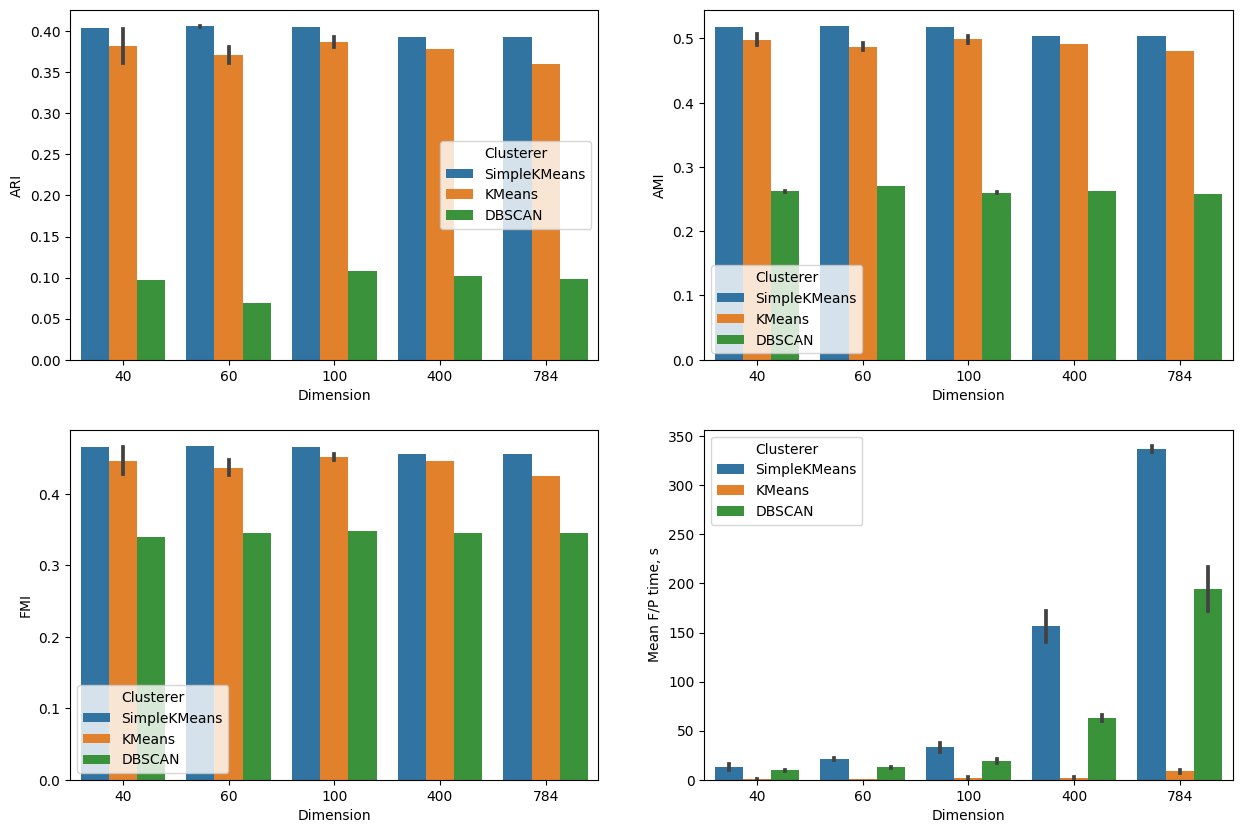

In [21]:
import seaborn as sns

R = pd.read_csv(RESULTS_PATH)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for m_name, ax in zip(
    ["ARI", "AMI", "FMI", "Mean F/P time, s"],
    axs.flatten(),
):
    sns.barplot(R, x="Dimension", y=m_name, hue="Clusterer", ax=ax)

Результаты:
* Скорость - SimpleKMeans очевидно оказался самым медленным, как минимум из-за отсутствия параллелизма. DBSCAN также очень долго работает по сравнению с реализацией KMeans из scikit-learn
* Качество - на всех метриках качество кастомной и библиотечной реализаций KMeans практически одинаково, но, на удивление, зачастую кастомная реализация чуть лучше. DBSCAN в свою очередь проигрывает KMeans с огромным отрывом по всем метрикам

Итог: наиболее эффективной по метрикам, оказалась кастомная реализация KMeans. В свою очередь, в рамках скорости, библиотечная реализация KMeans оказалась быстрее.